In [1]:
import matplotlib.pyplot as plt
import numpy as np

from qutip import * 
import os

# Matplotlib Einstellungen gemäß den LaTeX-Caption-Formatierungen
plt.rcParams.update({
#    'text.usetex': True,              # Enable LaTeX for text rendering
#    'font.family': 'serif',           # Use a serif font family
#    'font.serif': 'Palatino',         # Set Palatino as the serif font
#    'text.latex.preamble': r'\usepackage{amsmath}',
#    'font.size': 20,                   # Font size for general text
#    'axes.titlesize': 20,              # Font size for axis titles
#    'axes.labelsize': 20,              # Font size for axis labels
#    'xtick.labelsize': 20,             # Font size for x-axis tick labels
#    'ytick.labelsize': 20,             # Font size for y-axis tick labels
#    'legend.fontsize': 20,             # Font size for legends
#    'figure.figsize': [8, 6],          # Size of the plot (width x height)
#    'figure.autolayout': True,         # Automatic layout adjustment
#    'savefig.format': 'svg',           # Default format for saving figures
#    'figure.facecolor': 'none',        # Make the figure face color transparent
#    'axes.facecolor': 'none',          # Make the axes face color transparent
#    'savefig.transparent': True        # Save figures with transparent background
})
output_dir = r"C:\Users\leopo\OneDrive - UT Cloud\Uni\Semester_9\Master_thesis\Figures_From_Python"
os.makedirs(output_dir, exist_ok=True)

# allows for interactive plots
#%matplotlib notebook

$$
H = H_0 + H_I
$$
$$
H_0 = \hbar  \omega_a \sum_{i=1}^{N_{\text{atoms}}} \sigma_+^{(i)} \sigma_-^{(i)}
- \hbar \sum_{i,j=1}^{N_\text{{atoms}}} J_{i j} \sigma_+^{(i)} \sigma_-^{(j)}
+ \hbar \omega_c a^{\dagger}a
$$

$$
H_I = \hbar  g(t) \Sigma_x (a^{\dagger} + a).
$$

$$
\displaystyle J_{i j} = \frac{\alpha}{|r_i-r_j|}.
$$

In [7]:
# Set the system parameters
n_rings = 3
n_chains = 2 # number of chains
N_atoms = n_chains * n_rings  # number of atoms

fixed_lam = 1.                # energysplitting of the atom, when ground state is set to 0
omega_a = 2 * np.pi / fixed_lam # actually k_a
omega_c = omega_a
distance = 1 * fixed_lam # defining topology                                    0.1 <--
g0 = 1 # coupling strength between cavity and atomic system

gamma_0 = .1   # decay rate of the atoms
gamma_phi = .0 # dephasing rate of the atoms

alpha = 1. # coupling strength of the dipoles       Fine structure const?
mu    = 1. # dipole strength

# evolution
t_max = 10
time_steps = 10
t_step_width = t_max / time_steps
times = np.linspace(0, t_max, time_steps) # list of times

In [8]:
########################################               define the geometry                 #############################################
def chain_positions(distance, N_atoms):
    Pos = np.zeros((N_atoms, 3))
    for i in range(N_atoms):
        Pos[i, 2] = i * distance
    return Pos

def z_rotation(angle):
    return np.array([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle),  np.cos(angle), 0],
        [0,              0,            1]])

def ring_positions(distance, n_chains):
    Pos = np.zeros((n_chains, 3))
    dphi = 2 * np.pi / n_chains
    if n_chains == 1:
        radius = 0
    else:
        radius = distance / 2 / np.sin(np.pi / n_chains)
    helper = np.array([radius, 0, 0])
    for i in range(n_chains):
        rotation_matrix = z_rotation(dphi * i)
        Pos[i] = np.matmul(rotation_matrix, helper)
    return Pos

def cyl_positions(distance, N_atoms, n_chains):
    Pos = np.zeros((N_atoms, 3))
    Pos_chain = chain_positions(distance, N_atoms // n_chains)
    Pos_ring = ring_positions(distance, n_chains)
    for i in range(n_chains):
        Pos[i * (N_atoms // n_chains): (i + 1) * (N_atoms // n_chains)] = Pos_chain + Pos_ring[i]
    return Pos

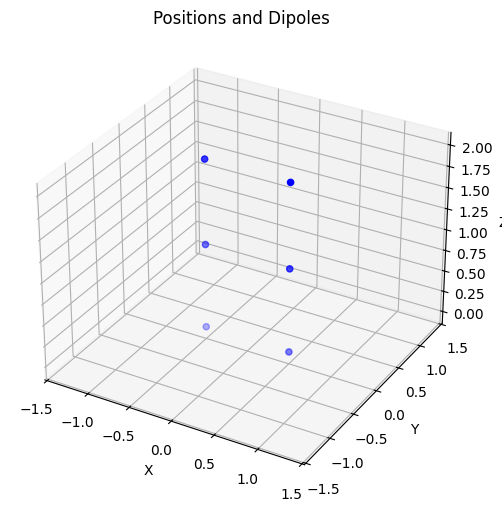

In [9]:
Pos = cyl_positions(distance, N_atoms, n_chains)

# Plotting 
fig = plt.figure(figsize=(8, 6)) 
ax = fig.add_subplot(111, projection='3d') 
# Plot the positions 
ax.scatter(Pos[:, 0], Pos[:, 1], Pos[:, 2], c='b', marker='o') 
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Positions and Dipoles')
ax.axis('equal')
plt.show()

In [10]:
# Define the ground & the excited states
# atomic dof
ground_state = basis(N_atoms + 1, 0)
excited_states = [basis(N_atoms + 1, i) for i in range(1, N_atoms + 1)]

# cavity dof
psi0 = basis(2, 0)
psi1 = basis(2, 1)

# combined dofs
sm_list = []
atomic_dip = 0
for i in range(N_atoms):
    op = tensor(qeye(2), ground_state * excited_states[i].dag())
    sm_list.append(op)
    atomic_dip += mu * op + mu * op.dag()

In [11]:
def Hamilton0(distance, n_rings, n_chains):
    N_atoms = n_chains * n_rings
    Pos = cyl_positions(distance, N_atoms, n_chains)
    H = 0
    for a in range(N_atoms):
        for b in range(N_atoms):
            base = sm_list[a].dag() * sm_list[b]
            if a != b:
                ra, rb = Pos[a, :], Pos[b, :]
                H += alpha / (np.linalg.norm(rb-ra))* base
            else:
                H +=  omega_a * base # Diagonals except for |0><0|
    H += omega_c * tensor([create(2)*destroy(2), ground_state*ground_state.dag()])
    return H
    
H0 = Hamilton0(distance, n_rings, n_chains)

H0

Quantum object: dims=[[2, 7], [2, 7]], shape=(14, 14), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         6.28318531 1.         0.5        1.         0.70710678
  0.4472136  0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         1.         6.28318531 1.         0.70710678 1.
  0.70710678 0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.5        1.         6.28318531 0.4472136  0.70710678
  1.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         1.         0.70710678 0.4472136  6.28318531 1.
  0.5        0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.70710678 1.         0.70710678 1.         6.28318531
  1.         0.         0.         0.         0.         0.
  0.         0.        ]
 

## Single case

$$
C_{\text{decay}}^{(i)} = \sqrt{\gamma_0} \sigma_-^{(i)} \quad
C_{\text{dephase}}^{(i)} = \sqrt{\gamma_\phi} \sigma_z^{(i)}
$$

## Collective case
$$
C_{\text{decay}} = \sum_{n=1}^{N_{\text{atoms}}} C_{\text{decay}}^{(i)} \quad
C_{\text{dephase}} = \sum_{n=1}^{N_\text{atoms}} C_{\text{dephase}}^{(i)}
$$

In [12]:
# Jump / Expect Operators
# Define the decay collapse and dephasing operator for each spin
c_op2 = [np.sqrt(gamma_0) * sm for sm in sm_list]                                                          # EVERY ATOM DECAYS on its own
c_op4 = [np.sqrt(gamma_phi) * commutator(sm.dag(), sm) for sm in sm_list]                                  # EVEY ATOM DEPHASES
c_op_list = c_op2 + c_op4
e_op_list = [tensor(psi0 * psi0.dag(),basis(N_atoms+1, i) * basis(N_atoms+1, i).dag()) for i in range(0,N_atoms+1)] #

In [13]:
# create the time dependant operator(s)
# interaction Operator
I = atomic_dip * tensor((create(2) + destroy(2)), qeye(N_atoms+1))

E12 = 10
E0s = [E12, E12, E12/10] # Probe pulse is smaller
omegas = [omega_a, omega_a, omega_a]
Delta_ts = [t_max/100, t_max/100, t_max/100] # narrow width of the pulses
t0s = [Delta_ts[0], Delta_ts[1], Delta_ts[2]]
#phi12 = 2  * np.pi         # phis = [phi12, phi12, 0]  # Phase-kick?, pulse 1 and 2 are phase locked!
def heaviside(x):
    return 1 if x >= 0 else 0

In [14]:
# evolution with t
# initial state
psiini = tensor([psi1, basis(N_atoms+1, 0)]) # = |1>_gamma ø |g>_atom

#
# PREPROCESSING
#
# Define the phases, coherence times, and waiting times
phases = [i * np.pi/2 for i in range(4)]

# Initialize the main dictionary to hold the structure
data_dict = {}
data_dict_stage1 = {}
data_dict_stage2 = {}

# Loop through each phase φ
for phi in phases:
    # Create a subdictionary for each phase
    data_dict[phi] = {}
    data_dict_stage1[phi] = {}  # Stage 1 copy of the phase
    data_dict_stage2[phi] = {}  # Stage 2 copy of the phase

# Print the resulting nested dictionary structure
import pprint
pprint.pprint(data_dict)

{0.0: {}, 1.5707963267948966: {}, 3.141592653589793: {}, 4.71238898038469: {}}


In [15]:
#
# The implementation in this code neglects different total timesy
#

def El_field(t, args):
    phi = args['phi']
    t0 = args['time']
    omega = args['omega']
    Delta = args['Delta']
    E0 = args['E0']
    E = 1 / np.sqrt(2) * E0 * heaviside(Delta - np.abs(t - t0)) * np.cos(np.pi*(t - t0)/(2*Delta))**2 * np.cos(omega * (t - t0) + phi)
    return E

H = [H0, [I, El_field]] # H1 with function-based time dependence, I is already defined

options = Options(store_states=True)

C:\Users\leopo\anaconda3\envs\Master\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


In [16]:
times_0 = times

# Iterate over the phi values
for phi in data_dict_stage1:
    args_0 = {
        'phi': phi,  # Use the phase from data_dict_stage1
        'time': Delta_ts[0],  # Second t0 value
        'omega': omegas[0],  # Second omega value
        'Delta': Delta_ts[0], # The width should be as wide as possible
        'E0': E0s[0]  # Second E0 value
    }

    # Solve the system using mesolve
    result_0 = mesolve(H, psiini, times_0, c_ops=c_op_list, args=args_0, options=options)

    current_dict = {}

    for i in range(len(times_0)):
        if (2 * (Delta_ts[0]) <= times_0[i] <= t_max - 2 * (Delta_ts[1] + Delta_ts[2])):
            current_dict[i] = result_0.states[i]  # tau is stored in the index i (key of the dictionary)

    if current_dict:  # Check if the dictionary is not empty
        data_dict_stage1[phi] = current_dict

#pprint.pprint(data_dict_stage1)

In [17]:
for phi, dic in data_dict_stage1.items():
    args_1 = {
        'phi': phi,  # Use the phase from data_dict_stage1
        'time': Delta_ts[1],  # Second t0 value
        'omega': omegas[1],  # Second omega value
        'Delta': Delta_ts[1], # The width should be as wide as possible
        'E0': E0s[1]  # Second E0 value
    }

    for i, psiini_1 in dic.items():
        times_1 = times[i:]
        # Solve the system using mesolve
        result_1 = mesolve(H, psiini_1, times_1, c_ops=c_op_list, args=args_1, options=options)

        current_dict = {}
        for j in range(len(times_1)):
            if (times[i] + 2 * (Delta_ts[1]) <= times_1[j] <= t_max - 2 * (Delta_ts[2])):
                current_dict[j] = result_1.states[j] # T is stored in the information j, together with i

        if current_dict:  # Check if the dictionary is not empty
            data_dict_stage2[phi][i] = current_dict

# After processing each coherence time, you can optionally print the current state of the dictionary
#pprint.pprint(data_dict_stage2)

In [18]:
data_dict = {}
for phi, dic in data_dict_stage2.items():
    args_2 = {
        'phi': 0,
        'time': Delta_ts[2],  # Duration for the 2nd pulse
        'omega': omegas[2],  # Omega for the 2nd pulse
        'Delta': Delta_ts[2],  # Delta for the 2nd pulse
        'E0': E0s[2]  # E0 for the 2nd pulse
    }

    for i, dic1 in dic.items():
        coherence_time_i = times[i] - Delta_ts[0] + Delta_ts[1]
        for j, psiini_2 in dic1.items():
             if i <= j - 2 * (Delta_ts[1]) / t_step_width:
                times_2 = times[j:]
                result_2 = mesolve(H, psiini_2, times_2, c_ops=c_op_list, args=args_2, options=options)
    
                waiting_time_j = times[j] - times[i] + Delta_ts[2] - Delta_ts[1]
    
                if phi not in data_dict:
                    data_dict[phi] = {}
                if coherence_time_i not in data_dict[phi]:
                    data_dict[phi][coherence_time_i] = {}
                if waiting_time_j not in data_dict[phi][coherence_time_i]:
                    data_dict[phi][coherence_time_i][waiting_time_j] = []
    
                # Iterate over the states in result_2 and store the ones that meet the time condition
                for k in range(len(times_2)):
                    if (times[j] + 2 * Delta_ts[2] <= times_2[k] and 
                            times_2[k] <= t_max):
                        data_dict[phi][coherence_time_i][waiting_time_j] = (times_2[k], result_2.states[k])
                        break  # Stop after saving the first valid pair

pprint.pprint(data_dict)
# The final data_dict will now contain the results for each φ, τ, and T

{0.0: {np.float64(1.1111111111111112): {np.float64(1.1111111111111112): (np.float64(3.3333333333333335),
                                                                         Quantum object: dims=[[2, 7], [2, 7]], shape=(14, 14), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 3.38702367e-01+1.29078683e-17j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  -1.66755831e-05+5.98739848e-04j -1.06199807e-04+7.67739271e-04j
  -1.66755831e-05+5.98739848e-04j -1.66755831e-05+5.98739848e-04j
  -1.06199807e-04+7.67739271e-04j -1.66755831e-05+5.98739848e-04j]
 [ 0.00000000e+00+0.00000000e+00j  8.29720362e-02+1.75514578e-17j
   1.09858945e-01+8.16062662e-03j  8.29720362e-02-2.45902761e-17j
   8.29720362e-02+5.40009708e-17j  1.09858945e-01+8.16062662e-03j
   8.29720362e-02+3.89101160e-17j -1.65476690e-02-5.1525

In [19]:
# Step 1: Average the states over the phi values
# Initialize a new dictionary for averaged results
averaged_data_dict = {}

# Iterate over tau, T, and t to average the states over phi
for phi, phi_dict in data_dict.items():
    for tau, tau_dict in phi_dict.items():
        if tau not in averaged_data_dict:
            averaged_data_dict[tau] = {}

        for T, T_dict in tau_dict.items():
            if T not in averaged_data_dict[tau]:
                averaged_data_dict[tau][T] = {}

            # Initialize a list to accumulate states for averaging
            accumulated_states = {}
            num_phi = len(data_dict)  # Number of phi values

            t, psi = T_dict[0], T_dict[1]
            # Collect states (psi) for the same tau, T, t values across all phi
            if t not in accumulated_states:
                accumulated_states[t] = []
            accumulated_states[t].append(psi)

            # Average the states across phi values
            for t, states in accumulated_states.items():
                # Sum all the states and divide by the number of phi values
                averaged_state = sum(states) / num_phi

            # Store the averaged energy component(t)
            averaged_data_dict[tau][T][t] = expect(atomic_dip, averaged_state) # This cant be it TODO

# Step 2: Reorganize the data such that states are indexed by tau, T, and t
reorganized_data_dict = {}

# Simply copy the averaged data into the reorganized structure
for tau, tau_dict in averaged_data_dict.items():
    for T, T_dict in tau_dict.items():
        for t, mu_mean in T_dict.items():
            if tau not in reorganized_data_dict:
                reorganized_data_dict[tau] = {}
            if T not in reorganized_data_dict[tau]:
                reorganized_data_dict[tau][T] = {}
            
            reorganized_data_dict[tau][T][t] = mu_mean

# The reorganized_data_dict will now have the states psi as a function of tau, T, and t

In [20]:
reorganized_data_dict

{np.float64(1.1111111111111112): {np.float64(1.1111111111111112): {np.float64(3.3333333333333335): 0.0},
  np.float64(2.2222222222222223): {np.float64(4.444444444444445): 0.0},
  np.float64(3.3333333333333335): {np.float64(5.555555555555555): 0.0},
  np.float64(4.444444444444445): {np.float64(6.666666666666667): 0.0},
  np.float64(5.555555555555555): {np.float64(7.777777777777779): 0.0},
  np.float64(6.666666666666668): {np.float64(8.88888888888889): 0.0}},
 np.float64(2.2222222222222223): {np.float64(1.1111111111111112): {np.float64(4.444444444444445): 0.0},
  np.float64(2.2222222222222223): {np.float64(5.555555555555555): 0.0},
  np.float64(3.333333333333333): {np.float64(6.666666666666667): 0.0},
  np.float64(4.444444444444445): {np.float64(7.777777777777779): 0.0}},
 np.float64(3.3333333333333335): {np.float64(1.1111111111111112): {np.float64(5.555555555555555): 0.0},
  np.float64(2.222222222222222): {np.float64(6.666666666666667): 0.0}}}